In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

In [3]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./ml-100k/u.data', sep='\t', names=header)

u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [4]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [5]:
from sklearn.model_selection import train_test_split
ratings_train, ratings_val = train_test_split(ratings, test_size=0.2)

In [6]:
n_split = 20000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(80000, 20000)

In [7]:
len(ratings_train), len(ratings_val)

(80000, 20000)

In [8]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1682 943 1650


In [9]:
max_rating = ratings_train['rating'].max()
min_rating = ratings_train['rating'].min()
av_rating = ratings_train['rating'].mean()
max_rating, min_rating, av_rating

(5, 1, 3.52835)

In [10]:
ratings_train['userId'].min(), ratings_train['movieId'].min()

(1, 1)

In [11]:
from keras.layers import Embedding, Input, Flatten, Dot, Add, Activation, Lambda
from keras.regularizers import l2
from keras import Model
from keras.constraints import non_neg

Using TensorFlow backend.


In [12]:
# En 3 casi no hay overfitting
n_latent_factors = 3

In [13]:
# l2_reg = l2(0.00025)
l2_reg = l2(0.00)
movie_input = Input(shape=[1], name='Item')
movie_embedding = Embedding(n_movies + 1, 
                            n_latent_factors, 
                            embeddings_regularizer = l2(0.001),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)
# Notar que la dimensión del embedding es 1 tanto para m_biases como para u_biases
m_biases = Flatten(name='movie_biases_flt')(Embedding(n_movies + 1, 1, name="movie_biases", embeddings_regularizer = l2_reg)(movie_input))

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,embeddings_regularizer = l2_reg,name='User-Embedding')(user_input))
u_biases = Flatten(name='user_biases_flt')(Embedding(n_users + 1, 1, name="user_biases", embeddings_regularizer = l2_reg)(user_input))

In [14]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
out = Add()([prod, u_biases, m_biases])
## Se pueden sacar las siguientes dos lineas para no forzar a sigmoidea
#out = Activation('sigmoid')(out)
#out = Lambda(lambda x: (max_rating - min_rating) * x + min_rating)(out)
##
model = Model([user_input, movie_input], out)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
____________________________________________________________________________________________

In [15]:
from keras.optimizers import Adam

In [16]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [17]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [18]:
model.compile(Adam(lr=0.001), 'mean_squared_error', metrics=[root_mean_squared_error])

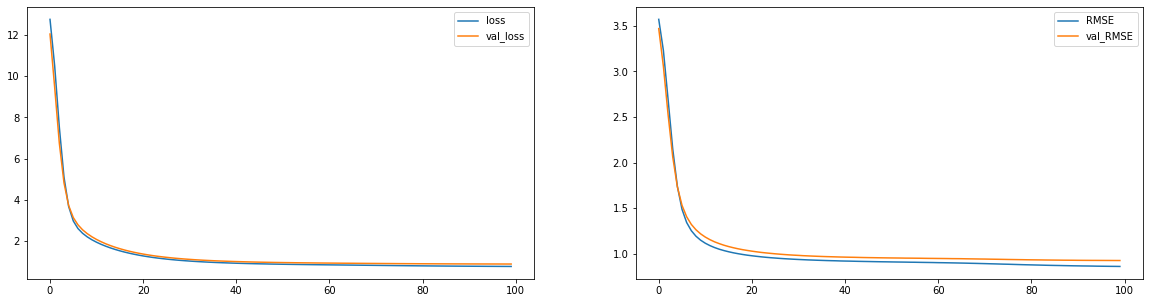

In [19]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=100, 
                    callbacks = [plot_losses],
                    verbose=1)

In [20]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

20000/20000 [==============================] - 1s 46us/step


[0.8880268263339997, 0.920022189617157]

In [21]:
model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)

80000/80000 [==============================] - 5s 62us/step


[0.7602928802609443, 0.8490187525749207]

In [22]:
model_analisis = Model([user_input, movie_input], [prod, u_biases, m_biases])

In [23]:
products_pred, u_biases_pred, m_biases_pred = model_analisis.predict([ratings_train.userId, ratings_train.movieId])

In [24]:
products_pred.shape

(80000, 1)

In [25]:
u_biases_pred.shape

(80000, 1)

In [26]:
m_biases_pred.shape

(80000, 1)